<a href="https://colab.research.google.com/github/makerseok/study-dl/blob/main/day02/day02_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 생존자 예측

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_row', 500)

### 데이터 로드

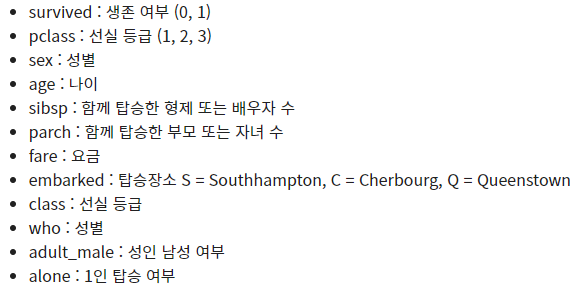

In [ ]:
raw_data = sns.load_dataset('titanic')
raw_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


## 데이터 전처리

In [ ]:
# 전처리가 끝난 값을 저장할 변수
clean_data = raw_data

### 중복 값 제거

In [ ]:
# age와 who가 같고, survived와 alive가 같으므로 각각 하나씩 남김
clean_data.drop(['who', 'alive'], axis=1, inplace=True)

In [ ]:
clean_data['embark_town'].value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

In [ ]:
clean_data['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [ ]:
# embark_town과 embarked 또한 같으므로 embark_town만 남김
clean_data.drop(['embarked'], axis=1, inplace=True)

### 결측값 처리

In [ ]:
# 결측값 수 확인
clean_data.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
class            0
adult_male       0
deck           688
embark_town      2
alone            0
dtype: int64

In [ ]:
# deck은 과반수 이상이 결측값이므로 drop
clean_data.drop('deck', axis=1, inplace=True)

In [ ]:
# embark_town은 2개의 결측값을 가지므로 결측값을 가진 행을 drop
clean_data.dropna(subset=['embark_town'], inplace=True)

In [ ]:
# fare가 0인 승객도 drop
clean_data['fare'] = clean_data['fare'].replace(0, np.nan)
clean_data.dropna(subset=['fare'], inplace=True)

In [ ]:
# age에 결측값을 포함할 경우도 drop
clean_data.dropna(subset=['age'], inplace=True)

In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     705 non-null    int64   
 1   pclass       705 non-null    int64   
 2   sex          705 non-null    object  
 3   age          705 non-null    float64 
 4   sibsp        705 non-null    int64   
 5   parch        705 non-null    int64   
 6   fare         705 non-null    float64 
 7   class        705 non-null    category
 8   adult_male   705 non-null    bool    
 9   embark_town  705 non-null    object  
 10  alone        705 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(2)
memory usage: 51.7+ KB


### 데이터 라벨링

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
clean_data

,survived,pclass,sex,age,sibsp,parch,fare,class,adult_male,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,Third,True,Southampton,False
1,1,1,female,38.0,1,0,71.2833,First,False,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,Third,False,Southampton,True
3,1,1,female,35.0,1,0,53.1000,First,False,Southampton,False
4,0,3,male,35.0,0,0,8.0500,Third,True,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Third,False,Queenstown,False
886,0,2,male,27.0,0,0,13.0000,Second,True,Southampton,True
887,1,1,female,19.0,0,0,30.0000,First,False,Southampton,True
889,1,1,male,26.0,0,0,30.0000,First,True,Cherbourg,True


In [ ]:
# 숫자 형식이 아닌 데이터 모두 라벨링
le = LabelEncoder()
clean_data['sex'] = le.fit_transform(clean_data['sex'])
clean_data['class'] = le.fit_transform(clean_data['class'])
clean_data['embark_town'] = le.fit_transform(clean_data['embark_town'])
clean_data['adult_male'] = le.fit_transform(clean_data['adult_male'])
clean_data['alone'] = le.fit_transform(clean_data['alone'])

In [ ]:
clean_data

,survived,pclass,sex,age,sibsp,parch,fare,class,adult_male,embark_town,alone
0,0,3,1,22.0,1,0,7.2500,2,1,2,0
1,1,1,0,38.0,1,0,71.2833,0,0,0,0
2,1,3,0,26.0,0,0,7.9250,2,0,2,1
3,1,1,0,35.0,1,0,53.1000,0,0,2,0
4,0,3,1,35.0,0,0,8.0500,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,39.0,0,5,29.1250,2,0,1,0
886,0,2,1,27.0,0,0,13.0000,1,1,2,1
887,1,1,0,19.0,0,0,30.0000,0,0,2,1
889,1,1,1,26.0,0,0,30.0000,0,1,0,1


## feature, target 분리

In [ ]:
feature_col = clean_data.columns[1:]
target_col = clean_data.columns[0]

In [ ]:
feature = clean_data[feature_col]
target = clean_data[target_col]

## feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(feature)
scaled_feature = pd.DataFrame(scaled_feature, columns=feature_col)
scaled_feature

,pclass,sex,age,sibsp,parch,fare,class,adult_male,embark_town,alone
0,0.909317,0.762048,-0.522747,0.515257,-0.509948,-0.521398,0.909317,0.858169,0.522863,-1.128802
1,-1.487201,-1.312253,0.579590,0.515257,-0.509948,0.685625,-1.487201,-1.165272,-2.036985,-1.128802
2,0.909317,-1.312253,-0.247163,-0.556295,-0.509948,-0.508674,0.909317,-1.165272,0.522863,0.885895
3,-1.487201,-1.312253,0.372902,0.515257,-0.509948,0.342871,-1.487201,-1.165272,0.522863,-1.128802
4,0.909317,0.762048,0.372902,-0.556295,-0.509948,-0.506318,0.909317,0.858169,0.522863,0.885895
...,...,...,...,...,...,...,...,...,...,...
700,0.909317,-1.312253,0.648486,-0.556295,5.326305,-0.109056,0.909317,-1.165272,-0.757061,-1.128802
701,-0.288942,0.762048,-0.178267,-0.556295,-0.509948,-0.413011,-0.288942,0.858169,0.522863,0.885895
702,-1.487201,-1.312253,-0.729435,-0.556295,-0.509948,-0.092562,-1.487201,-1.165272,0.522863,0.885895
703,-1.487201,0.762048,-0.247163,-0.556295,-0.509948,-0.092562,-1.487201,0.858169,-2.036985,0.885895


## 데이터를 train과 test로 분리

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_feature, target, test_size=.3, stratify=target
)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (493, 10)
y_train shape: (493,)
X_test shape: (212, 10)
y_test shape: (212,)


## 모델 생성

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=10, activation='relu'))
model.add(Dropout(0.5)) # 과적합 방지를 위한 규제(망각)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7)) # 과적합 방지를 위한 규제(망각)
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.7)) # 과적합 방지를 위한 규제(망각)
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 64)                704       
_________________________________________________________________
dropout_133 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_134 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_135 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_184 (Dense)            (None, 1)               

## 모델 학습

In [ ]:
model.compile(loss='binary_crossentropy', # 손실함수
              optimizer='adam', # 정규화기
              metrics=['binary_accuracy']) # 평가 기준(학습에 영향 x)
fit_hist = model.fit(X_train, y_train, batch_size=64,
                     epochs=100, validation_split=0.2)

Epoch 1/100
7/7 [==============================] - 1s 32ms/step - loss: 0.7828 - binary_accuracy: 0.4772 - val_loss: 0.6728 - val_binary_accuracy: 0.6768
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.7468 - binary_accuracy: 0.5228 - val_loss: 0.6617 - val_binary_accuracy: 0.7172
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.7173 - binary_accuracy: 0.5736 - val_loss: 0.6547 - val_binary_accuracy: 0.7374
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6972 - binary_accuracy: 0.6218 - val_loss: 0.6485 - val_binary_accuracy: 0.7273
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.7186 - binary_accuracy: 0.5660 - val_loss: 0.6441 - val_binary_accuracy: 0.7475
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6655 - binary_accuracy: 0.6041 - val_loss: 0.6411 - val_binary_accuracy: 0.7576
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6833 - b

## 결과 확인

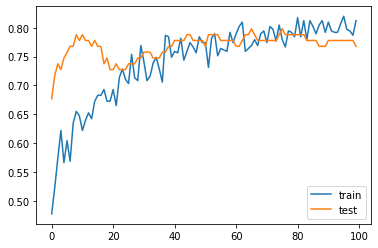

In [ ]:
# train, test accuracy 확인
plt.plot(fit_hist.history['binary_accuracy'], label='train')
plt.plot(fit_hist.history['val_binary_accuracy'], label='test')
plt.legend(loc='best')
plt.show()

In [ ]:
# 해당 모델의 loss와 accuracy
score = model.evaluate(X_test, y_test, verbose=1)
print('Keras DNN model loss:', score[0])
print('Keras DNN model accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3846 - binary_accuracy: 0.8679
Keras DNN model loss: 0.3846142590045929
Keras DNN model accuracy: 0.8679245114326477


In [ ]:
# confusion matrix, f1 score 확인
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
pred = model.predict(X_test)
pred = (pred > 0.5)
print(confusion_matrix(y_test, pred))
print(f1_score(y_test, pred, average='micro'))

[[108  18]
 [ 10  76]]
0.8679245283018869


# 테스트용

In [ ]:
error^^

SyntaxError: ignored

In [ ]:
age_drop = clean_data.dropna(subset=['age'])

In [ ]:
age_drop.corr()

In [ ]:
age_target_col = age_drop[['age']].columns
age_feature_col = age_drop.columns.difference(['age'])

In [ ]:
age_target_col, age_feature_col.shape

In [ ]:
age_feature = age_drop[age_feature_col]
age_target = age_drop[age_target_col]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(age_feature)
scaled_feature = pd.DataFrame(scaled_feature, columns=age_feature_col)
scaled_feature

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=10, activation='relu'))
model.add(Dropout(0.5)) # 과적합 방지를 위한 규제(망각)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # 과적합 방지를 위한 규제(망각)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # 과적합 방지를 위한 규제(망각)
model.add(Dense(1))
model.summary()

In [ ]:
age_feature.info()

In [ ]:
model.compile(loss='mse', # 손실함수
              optimizer='adam', # 정규화기
              metrics=['mae', 'mse']) # 평가 기준(학습에 영향 x)
fit_hist = model.fit(age_feature.values, age_target.values, batch_size=50, epochs=100, validation_split=0.3)

In [ ]:
# train, test accuracy 확인
plt.plot(fit_hist.history['mae'], label='train')
plt.plot(fit_hist.history['val_mae'], label='test')
plt.legend(loc='best')
plt.show()

In [ ]:
model.predict(clean_data[clean_data.columns.difference(['age'])])